In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
from progressbar import ProgressBar

Mounted at /content/drive


In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel, Matern
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, auc, roc_curve, classification_report, recall_score
from progressbar import ProgressBar
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import product
import random
import seaborn as sns

In [ ]:
def first_sample(df, sample_length):
  
  # ID hotspots
  df['hotspot'] = df['case_pop_ratio'].apply(lambda x: 1 if x > np.percentile(df['case_pop_ratio'], 85) else 0)

  # Sample points and train initial GPC
  df_sample = df.sample(sample_length)
  gpc = GaussianProcessClassifier(kernel=Matern([1.5, 1.5], nu=2.5) + WhiteKernel(10) + ConstantKernel())
  gpc.fit(df_sample[['longitude', 'latitude']], df_sample['hotspot'])

  # Make predictions
  pred_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['longitude', 'latitude'])
  Y_hat = gpc.predict_proba(pred_df)[:, 1]
  
  # Scale predictions to attempt calibration
  scaler = MinMaxScaler()
  Y_hat = scaler.fit_transform(Y_hat.reshape(-1, 1))
  pred_df['Y_hat'] = Y_hat

  # Fit NN model to match predictions to sample locations
  knn = NearestNeighbors(n_neighbors=1)
  knn.fit(pred_df[['longitude', 'latitude']])

  distances, knn_indices = knn.kneighbors(df[['longitude', 'latitude']])
  df['Y_hat'] = pred_df.iloc[[i[0] for i in knn_indices]]['Y_hat'].reset_index(drop=True)
  df['predicted_hotspot'] = df['Y_hat'].apply(lambda x: 1 if x > 0.5 else 0)

  return gpc, Y_hat, knn_indices, df, df_sample

In [ ]:
def sampling_round(gpc, Y_hat, df, knn_indices, df_sample, sample_length, explore_weight=0.5, exploit_weight=0.5):

  # Compute entropy associated with each prediction (for exploit score)
  df['entropy'] = -np.log(df['Y_hat']) * df['Y_hat']

  # Get sum of distances from each previously sampled point to identify farthest points (for explore score)
  start = True
  for x_point, y_point in zip(df_sample['latitude'], df_sample['longitude']):

    if start:
      distance_df = pd.DataFrame(df.apply(lambda x: ((x['latitude'] - y_point) ** 2) + ((x['longitude'] - x_point) ** 2), axis=1))
      start = False

    else:
      distance_df = pd.concat([distance_df, df.apply(lambda x: ((x['latitude'] - y_point) ** 2) + ((x['longitude'] - x_point) ** 2), axis=1)], axis=1)

  df['sample_distance'] = distance_df.sum(axis=1)

  # Scale entropy and distance using standard scaler 
  scaler = StandardScaler()
  df[['scaled_entropy', 'scaled_distance']] = scaler.fit_transform(df[['entropy', 'sample_distance']])

  # Adjust tradeoff between explore & exploit to generate acquisition function, default is equal weight
  df['sampling_acquisition_function'] = (explore_weight * df['scaled_distance']) + (exploit_weight * df['scaled_entropy'])

  # Sample points with highest values for acquisition function and add to previous sample (ignoring previous samples)
  df = df.sort_values(by='sampling_acquisition_function', ascending=False)
  df_sample = df_sample.append(df[~df['city-id'].isin(df_sample['city-id'])].reset_index(drop=True).iloc[:sample_length], ignore_index=True)

  # Fit new GPC & return performance metrics
  gpc.fit(df_sample[['longitude', 'latitude']], df_sample['hotspot'])
  pred_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns = ['longitude', 'latitude'])
  Y_hat = gpc.predict_proba(pred_df)[:, 1]
  
  # Scale predictions to attempt calibration
  scaler = MinMaxScaler()
  Y_hat = scaler.fit_transform(Y_hat.reshape(-1, 1))
  
  pred_df['Y_hat'] = Y_hat

  df['Y_hat'] = pred_df.iloc[[i[0] for i in knn_indices]]['Y_hat'].reset_index(drop=True)
  df['predicted_hotspot'] = df['Y_hat'].apply(lambda x: 1 if x > 0.5 else 0)

  y_test = df['hotspot']
  pred = df['predicted_hotspot']

  accuracy = accuracy_score(y_test, pred)
  recall = recall_score(y_test, pred)

  return gpc, Y_hat, knn_indices, df, df_sample, accuracy, recall 

In [ ]:
br_df = pd.read_csv('/content/drive/MyDrive/Brazil COVID Data/cleaned_data.csv')

In [ ]:
# Initially we do not consider time series, just look at last entry and consider cases for all time

df = br_df[br_df['date'] == br_df['date'].max()].reset_index(drop=True)
df['case_pop_ratio'] = df['cumulative_cases'] / df['population_2019']
df['city-id'] = df['city'] + ', ' + df['state'] + ', ' + df['region']

In [ ]:
len(df)

5570

In [ ]:
x = np.linspace(df['longitude'].min(), df['longitude'].max(), 100)
y = np.linspace(df['latitude'].min(), df['latitude'].max(), 100)
xx, yy = np.meshgrid(x,y)

In [ ]:
gpc, Y_hat, knn_indices, df, df_sample = first_sample(df, sample_length=100)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


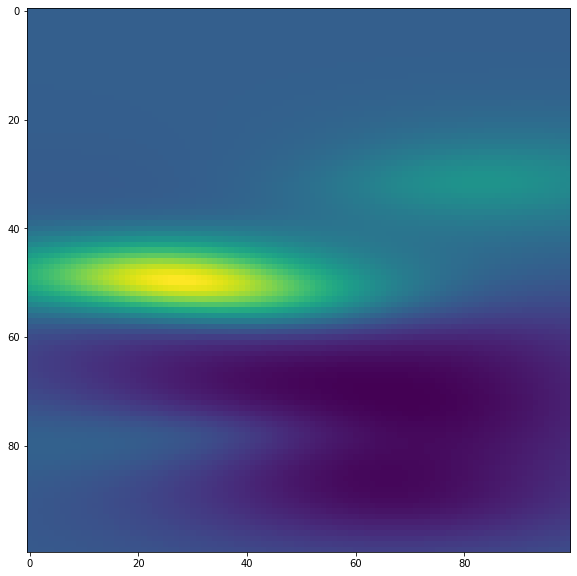

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(Y_hat.reshape(100, 100).T)

In [ ]:
df['Y_hat'].describe()

count    5570.000000
mean        0.280942
std         0.304192
min         0.000000
25%         0.042145
50%         0.124675
75%         0.463070
max         1.000000
Name: Y_hat, dtype: float64

In [ ]:
results = []
pbar = ProgressBar()

for i in pbar(range(50)):
  gpc, Y_hat, knn_indices, df, df_sample, accuracy, recall  = sampling_round(gpc, Y_hat, df, knn_indices, df_sample, sample_length=10)
  results.append([i, accuracy, recall])

N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
  2% (1 of 50) |                         | Elapsed Time: 0:00:08 ETA:   0:07:01/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the s

KeyboardInterrupt: ignored

In [ ]:
df['Y_hat'].describe()

count    5570.000000
mean        0.252764
std         0.256308
min         0.000316
25%         0.060405
50%         0.120612
75%         0.386016
max         1.000000
Name: Y_hat, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


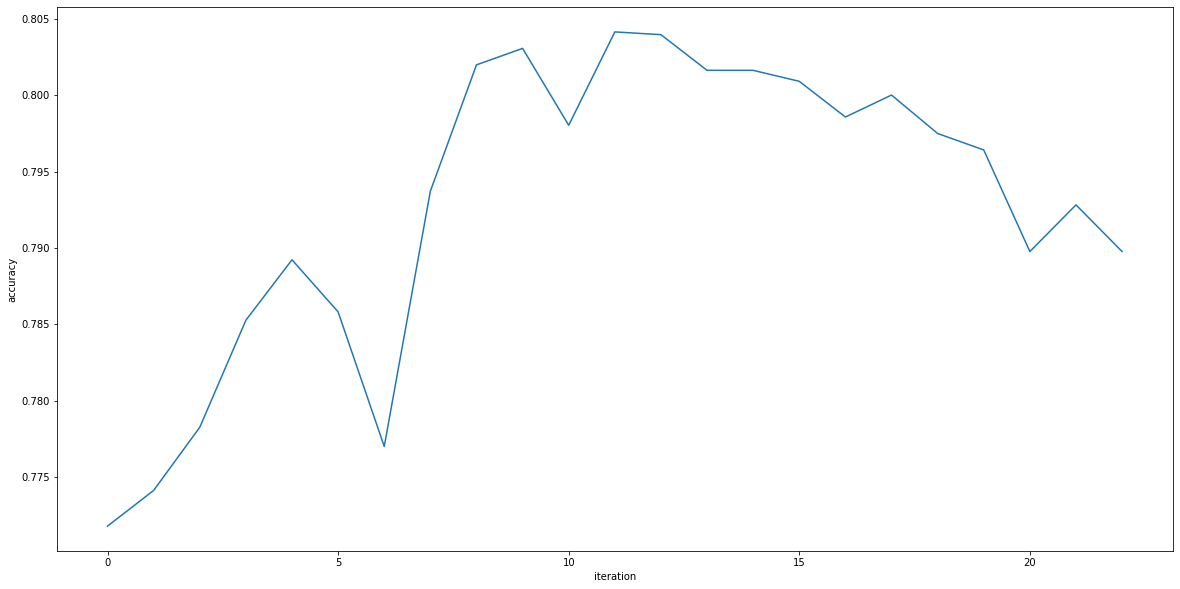

In [ ]:
results_df = pd.DataFrame(results, columns = ['iteration', 'accuracy', 'recall'])
plt.figure(figsize=(20,10))
sns.lineplot(results_df['iteration'], results_df['accuracy'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


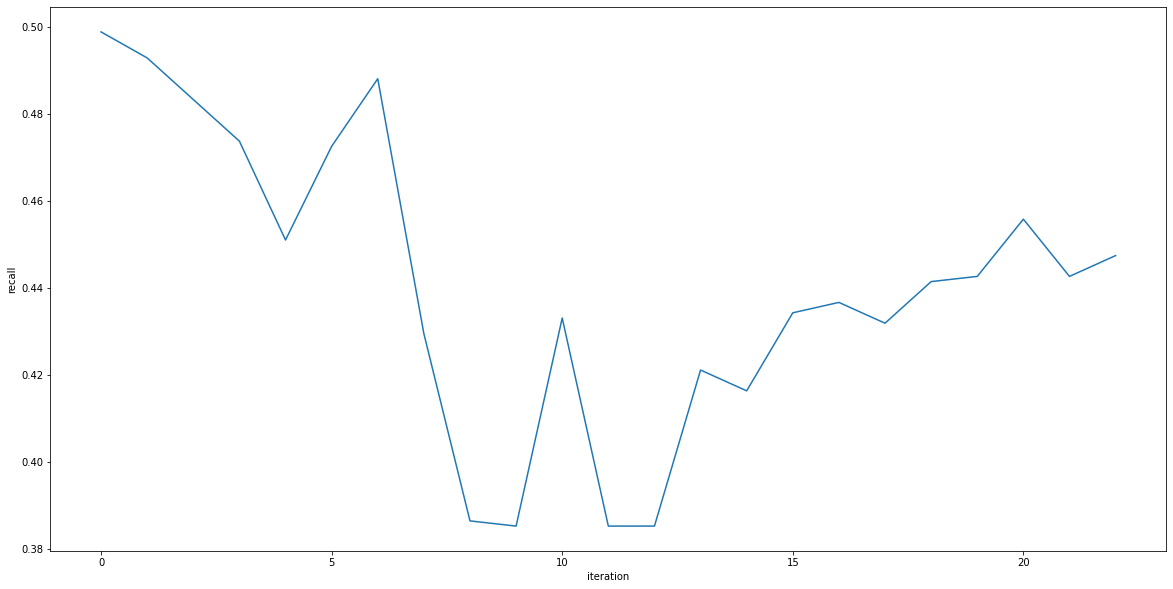

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(results_df['iteration'], results_df['recall'])

In [ ]:
len(df_sample)

330

In [ ]:
df_sample['city-id'].value_counts()

Gramado dos Loureiros, RS, Sul      1
Medicilândia, PA, Norte             1
Anori, AM, Norte                    1
Codajás, AM, Norte                  1
Tapauá, AM, Norte                   1
                                   ..
São Paulo de Olivença, AM, Norte    1
Porto Walter, AC, Norte             1
Benjamin Constant, AM, Norte        1
Tabatinga, AM, Norte                1
Vale do Anari, RO, Norte            1
Name: city-id, Length: 330, dtype: int64

In [ ]:
gpc.n_classes_

2

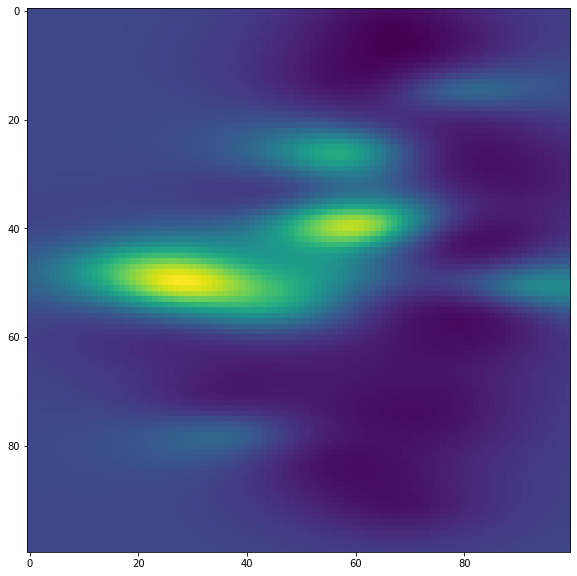

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(Y_hat.reshape(100, 100).T)

In [ ]:
df['Y_hat'].describe()

count    5570.000000
mean        0.252764
std         0.256308
min         0.000316
25%         0.060405
50%         0.120612
75%         0.386016
max         1.000000
Name: Y_hat, dtype: float64

In [ ]:
np.percentile(df['Y_hat'], 50)

0.12061213823883649

In [ ]:
df['predicted_hotspot2'] = df['Y_hat'].apply(lambda x: 1 if x > np.percentile(df['Y_hat'], 75) else 0)

In [ ]:
y_test = df['hotspot']
pred = df['predicted_hotspot2']

accuracy = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)

In [ ]:
print(accuracy)

0.7678635547576301


In [ ]:
print(recall)

0.5598086124401914


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      4734
           1       0.34      0.56      0.42       836

    accuracy                           0.77      5570
   macro avg       0.62      0.68      0.64      5570
weighted avg       0.83      0.77      0.79      5570



In [ ]:
df['predicted_hotspot2'].value_counts()

0    4177
1    1393
Name: predicted_hotspot2, dtype: int64

In [ ]:
# check stability for multiple rounds - we should see consistent distributions for hotspot probability 

In [ ]:
# Adjust first sample & batch sizes 
# Adjust number of sampling rounds
# Adjust tradeoff of explore vs exploit 

init_batch_sizes = [10, 20, 50]
batch_sizes = [1, 5, 10, 20, 50]
total_iterations = 100
explore_weights = [0.05, 0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9, 0.95]

# GRID SEARCH
'''
results = []
num_combos = len(init_batch_sizes) * len(batch_sizes) * len(explore_weights)
counter = 0

for init_batch_size in init_batch_sizes:
  for batch_size in batch_sizes:
    for weight in explore_weights:
      
      print('running combo', str(counter), '/', str(num_combos))

      num_iterations = (total_iterations - init_batch_size) / batch_size
      gpc, Y_hat, knn_indices, df, df_sample = first_sample(df, sample_length=init_batch_size)
      pbar = ProgressBar()

      for i in pbar(range(int(num_iterations))):
        gpc, Y_hat, knn_indices, df, df_sample, accuracy, recall  = sampling_round(gpc, Y_hat, df, knn_indices, df_sample, sample_length=batch_size, explore_weight=weight, exploit_weight=1-weight)
        results.append([init_batch_size, batch_size, weight, i, accuracy, recall]) 
      
      counter += 1 
'''
  

"\nresults = []\nnum_combos = len(init_batch_sizes) * len(batch_sizes) * len(explore_weights)\ncounter = 0\n\nfor init_batch_size in init_batch_sizes:\n  for batch_size in batch_sizes:\n    for weight in explore_weights:\n      \n      print('running combo', str(counter), '/', str(num_combos))\n\n      num_iterations = (total_iterations - init_batch_size) / batch_size\n      gpc, Y_hat, knn_indices, df, df_sample = first_sample(df, sample_length=init_batch_size)\n      pbar = ProgressBar()\n\n      for i in pbar(range(int(num_iterations))):\n        gpc, Y_hat, knn_indices, df, df_sample, accuracy, recall  = sampling_round(gpc, Y_hat, df, knn_indices, df_sample, sample_length=batch_size, explore_weight=weight, exploit_weight=1-weight)\n        results.append([init_batch_size, batch_size, weight, i, accuracy, recall]) \n      \n      counter += 1 \n"

In [ ]:
# Prep hyperparameter combos for random search 

combos = []

for combo in product(init_batch_sizes, batch_sizes, explore_weights):
  combos.append(combo)

random_selected_combos = random.sample(combos, k=25)

In [ ]:
random_selected_combos

[(10, 20, 0.25),
 (50, 5, 0.05),
 (50, 5, 0.9),
 (20, 1, 0.25),
 (10, 5, 0.66),
 (10, 1, 0.1),
 (20, 20, 0.66),
 (20, 50, 0.66),
 (20, 50, 0.9),
 (10, 10, 0.9),
 (10, 50, 0.5),
 (10, 20, 0.9),
 (50, 1, 0.25),
 (50, 10, 0.95),
 (20, 5, 0.9),
 (10, 20, 0.5),
 (20, 1, 0.66),
 (20, 1, 0.33),
 (20, 1, 0.1),
 (10, 20, 0.05),
 (50, 10, 0.66),
 (10, 50, 0.33),
 (10, 20, 0.66),
 (10, 50, 0.05),
 (10, 10, 0.95)]

In [ ]:
 # RANDOM SEARCH 
total_iterations = 1000
results = []
num_combos = len(random_selected_combos)
counter = 0

for init_batch_size, batch_size, weight in random_selected_combos:
    
    print('running combo', str(counter), '/', str(num_combos))

    num_iterations = (total_iterations - init_batch_size) / batch_size
    
    try:
      gpc, Y_hat, knn_indices, df, df_sample = first_sample(df, sample_length=init_batch_size)
    except ValueError: # Error occurs if there are not both instances of classes for GPC, resample
      gpc, Y_hat, knn_indices, df, df_sample = first_sample(df, sample_length=init_batch_size)

    pbar = ProgressBar()

    for i in pbar(range(int(num_iterations))):
      gpc, Y_hat, knn_indices, df, df_sample, accuracy, recall  = sampling_round(gpc, Y_hat, df, knn_indices, df_sample, sample_length=batch_size, explore_weight=weight, exploit_weight=1-weight)
      results.append([init_batch_size, batch_size, weight, i, accuracy, recall]) 
    
    pd.DataFrame(results, columns = ['init_batch_size', 'batch_size', 'weight', 'iteration', 'accuracy', 'recall']).to_csv('/content/drive/MyDrive/Brazil COVID Data/1000_iter_hp_random_search_results_' + str(counter) + '.csv', index=False)

    counter += 1 

running combo 0 / 25


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
N/A% (0 of 49) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for d

running combo 1 / 25


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
N/A% (0 of 190) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for d

KeyboardInterrupt: ignored

In [ ]:
df.info()

In [ ]:
df.to_csv('br-data.csv', index=False)